In [1]:
%matplotlib inline
from __future__ import division, print_function
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
import sys, os, time
import fitsio
import healpy as hp
from sklearn import cluster

In [2]:
t = Table.read('/Users/roz18/git/desi-photoz/test/clustering_results.txt', format='ascii.commented_header')

ra = np.array(t['ra'])
dec = np.array(t['dec'])
density = np.array(t['density'])
counts = np.array(t['count'])
labels = np.array(t['label'])

n_clusters = len(np.unique(labels))
print(len(t), 'pixels')
print(int(np.sum(counts)), 'objects')

5205 pixels
4634978 objects


In [3]:
NSIDE = 2**7
npix = hp.nside2npix(NSIDE)
c = 1/(41253/npix)

pix_id = hp.pixelfunc.ang2pix(NSIDE, ra, dec, lonlat=True)
m = np.zeros(npix)
m[pix_id] = density
m = hp.ma(m)
m.mask = ~np.array(m, dtype=bool)

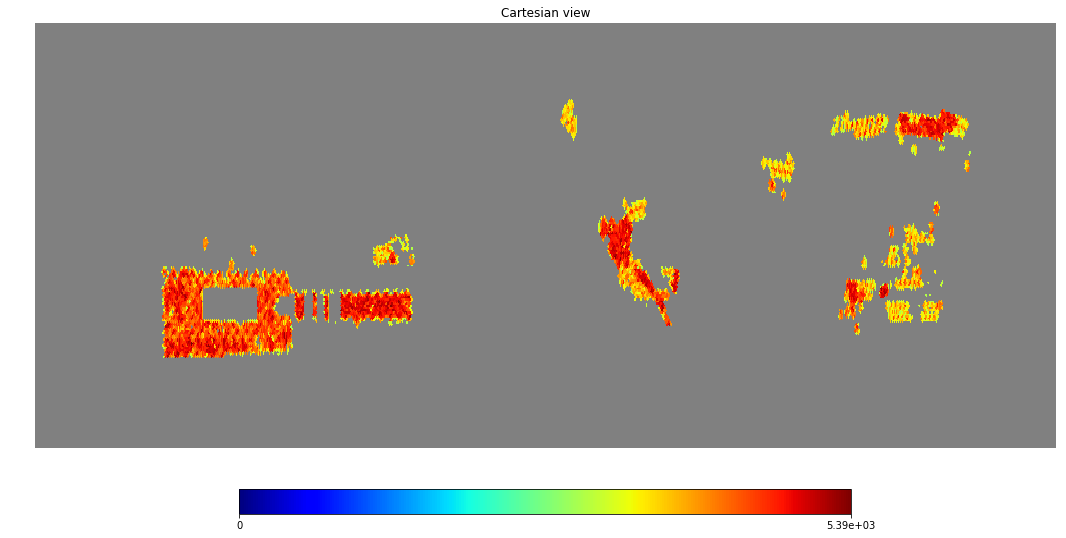

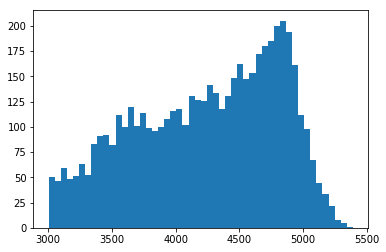

In [4]:
plt.rcParams['image.cmap'] = 'jet'
plt.figure(figsize=(20, 8))
hp.cartview(m, min=0, rot=(-90, 0, 0), fig=1, latra=(-20, 40), aspect=2.5, xsize=2000)
plt.show()

plt.hist(density, 50)
plt.show()

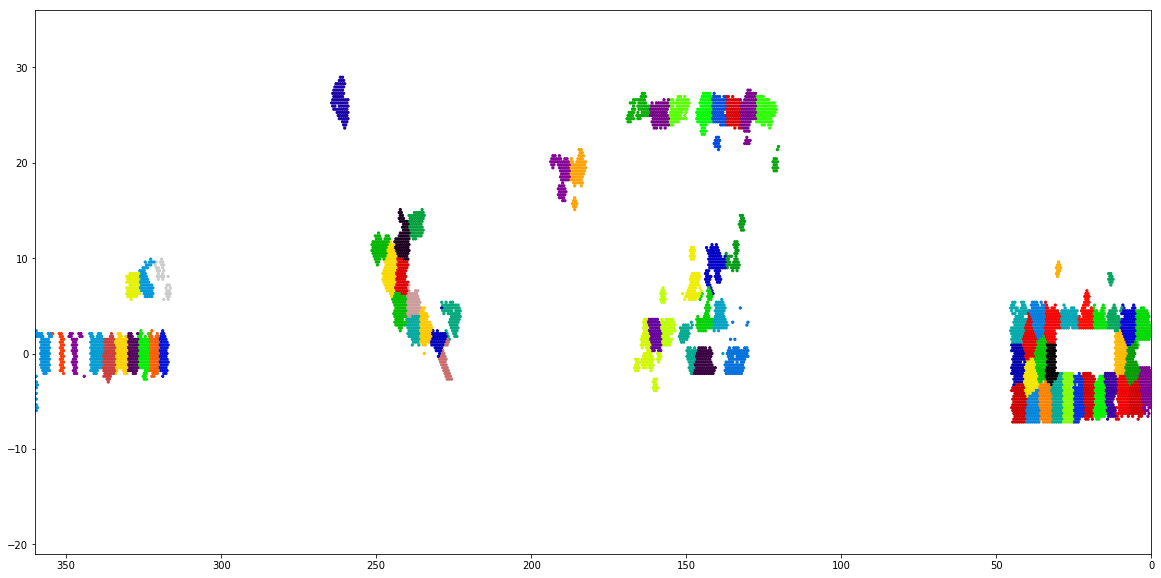

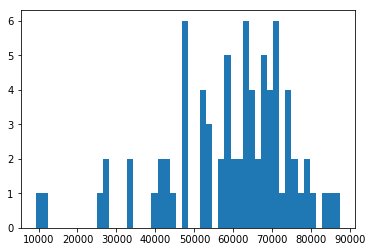

In [5]:
plt.figure(figsize=(20, 10))
plt.scatter(ra, dec, c=labels, cmap=plt.cm.spectral, s=5)
plt.axis([360, 0, -21, 36])
plt.show()

group_counts_original = np.zeros(n_clusters)
for idx_grp in range(n_clusters):
    members = np.where(labels==idx_grp)[0]
    group_counts_original[idx_grp] = np.sum(counts[members])
plt.hist(group_counts_original, 50)
plt.show()

__Identify the neighbors of each occupied pixel:__

In [8]:
neighbors = hp.get_all_neighbours(NSIDE, ra, dec, lonlat=True).T
mask = np.in1d(neighbors, pix_id).reshape(neighbors.shape)
neighbors[~mask] = -1

# Convert to native numpy indices of the pixels
# pointer from healpy indices to pixel indices:
pointer = -99 * np.ones(npix, dtype=int)
for index in range(len(ra)):
    pointer[pix_id[index]] = index
neighbors[mask] = pointer[neighbors[mask]]

# # Verify that the neighbor-finding is correct
# plt.figure(figsize=(20, 10))
# plt.plot(ra[neighbors[mask]], dec[neighbors[mask]], '.', markersize=5)
# plt.axis([360, 0, -21, 36])
# plt.show()

In [7]:
# # Find lone pixels
# mask = neighbors>=0
# mask_loner = ~np.any(mask, axis=1)
# print(np.sum(mask_loner), 'lone pixels')
# plt.figure(figsize=(20, 10))
# plt.plot(ra[~mask_loner], dec[~mask_loner], '.', markersize=5)
# plt.plot(ra[mask_loner], dec[mask_loner], 'r.', markersize=5)
# plt.axis([360, 0, -21, 36])
# plt.show()

# # Find bordering pixels
# mask1 = labels[neighbors] != labels[:, None]
# mask2 = neighbors>=0
# mask_border = np.any(mask1 & mask2, axis=1)
# print(np.sum(mask_border), 'bordering pixels')
# plt.figure(figsize=(20, 10))
# plt.plot(ra[~mask_border], dec[~mask_border], '.', markersize=5)
# plt.plot(ra[mask_border], dec[mask_border], 'r.', markersize=5)
# plt.axis([360, 0, -21, 36])
# plt.show()

In [8]:
# Default parameters:
default_params = {
    'pop_size': 50,   # population size
    'surv_rate': 0.5,
    'mutate_rate': 0.0015,
    'ngen': 4000,  # number of generations to run
    'tournament_k':3, # number of individuals in tournament selection
    'equality_weight': 250., # weight of imposing equal weighted pix counts in fitness function
    'spherical': True, 
}

In [9]:
from optimized_pixel_partition import Subsampler

# Initialize
optimizer = Subsampler(ra, dec, labels, neighbors, weights=counts, **default_params)

-----------
__Evolve!__

In [10]:
# optimizer.equality_weight = 150.

In [11]:
# np.random.seed(2)

############################## Evolve! ##############################
for idx_gen in range(default_params['ngen']):

    # update the fitness scores
    optimizer.fitness()
    
    # print status
    best = np.argmax(optimizer.scores)
    if idx_gen%10==0:
        print('{:5d} {:11.8g} {:11.8g} {:11.8g}'.\
              format(idx_gen, optimizer.scores[best], optimizer.compactness[best], optimizer.equality[best]))

    # select survivers
    survivers, scores = optimizer.selection()
    
    # rebuild solution array and mutate
    optimizer.labels_all = optimizer.labels_all[survivers]
    optimizer.mutate()

    0  -199.90887   133.69159   66.217283
   10  -199.59955   133.74599   65.853564
   20  -199.28441   133.89836   65.386054
   30   -198.9043    134.0158   64.888495
   40  -198.58467   134.10495   64.479717
   50  -198.29687   134.17755   64.119326
   60  -197.94407   134.25347   63.690602
   70    -197.562   134.38409   63.177908
   80  -197.25246   134.40923   62.843227
   90  -196.91373   134.57633   62.337396
  100  -196.69132    134.6313   62.060023
  110  -196.41247   134.69895   61.713524
  120  -196.14675   134.77512   61.371632
  130  -195.90153   134.84561   61.055926
  140  -195.71472   134.87467   60.840047
  150  -195.55695   134.93009   60.626863
  160  -195.32046   134.92711   60.393351
  170  -195.16329   134.98655   60.176737
  180  -194.99003   135.10915   59.880872
  190  -194.81704   135.10949   59.707554
  200  -194.67416   135.08417   59.589989
  210  -194.54031   135.16349    59.37682
  220  -194.38797   135.10282   59.285145
  230  -194.26799   135.16501   59

 1960  -188.25058   137.13694   51.113643
 1970  -188.24656   137.14051   51.106052
 1980  -188.24656   137.14051   51.106052
 1990  -188.24619   137.13772   51.108467
 2000  -188.24471    137.1956   51.049115
 2010  -188.24072   137.15281   51.087911
 2020  -188.22937   137.15826   51.071103
 2030   -188.2285   137.17353   51.054974
 2040  -188.22643   137.17269   51.053745
 2050  -188.22087   137.17026   51.050607
 2060  -188.21758     137.158   51.059582
 2070  -188.20909   137.18909   51.020002
 2080   -188.2028    137.1825   51.020306
 2090  -188.18965   137.17873   51.010915
 2100  -188.18652    137.1589   51.027619
 2110  -188.18652    137.1589   51.027619
 2120  -188.17901    137.1504   51.028614
 2130  -188.17542   137.15111   51.024311
 2140  -188.17075   137.15677   51.013982
 2150  -188.16886   137.13138   51.037479
 2160  -188.15934   137.11837   51.040971
 2170  -188.15312   137.09751   51.055616
 2180  -188.15051   137.09312   51.057395
 2190  -188.14156   137.08971   51

 3920  -187.39623   136.58524   50.810987
 3930  -187.39623   136.58524   50.810987
 3940  -187.39623   136.58524   50.810987
 3950  -187.39623   136.58524   50.810987
 3960  -187.39623   136.58524   50.810987
 3970  -187.39623   136.58524   50.810987
 3980  -187.39623   136.58524   50.810987
 3990  -187.39623   136.58524   50.810987


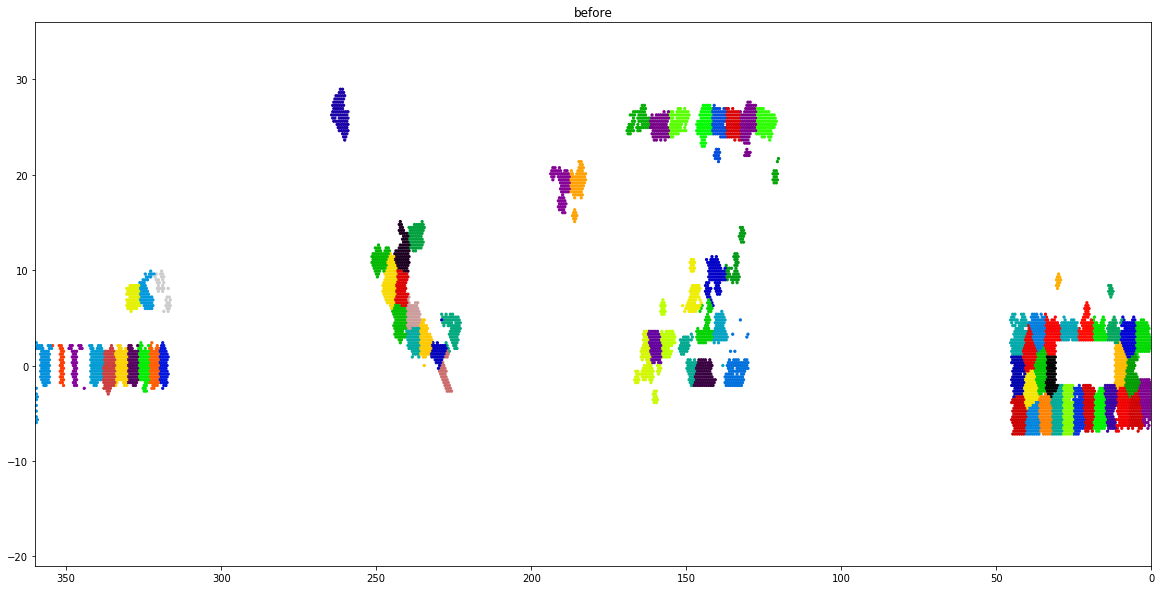

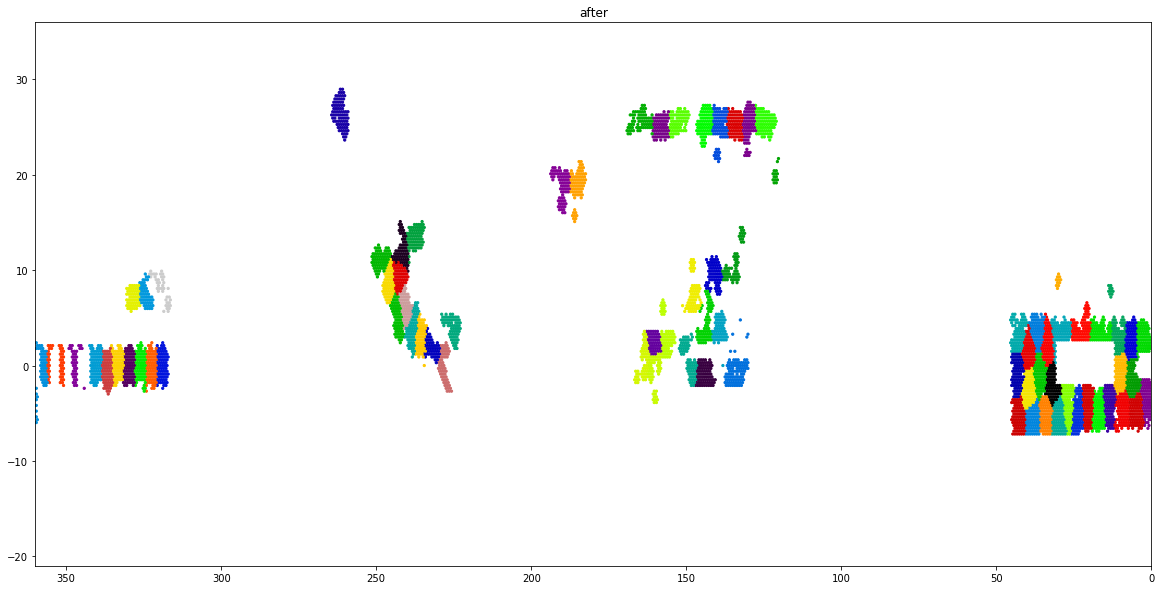

In [33]:
# Original grouping
plt.figure(figsize=(20, 10))
plt.scatter(ra, dec, c=labels, cmap=plt.cm.spectral, s=5)
plt.axis([360, 0, -21, 36])
plt.title('before')
plt.show()

# Final grouping
best = np.argsort(optimizer.scores)[-1]
plt.figure(figsize=(20, 10))
plt.scatter(ra, dec, c=optimizer.labels_all[best], cmap=plt.cm.spectral, s=5)
plt.axis([360, 0, -21, 36])
plt.title('after')
plt.show()

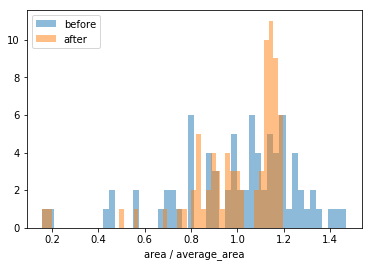

In [34]:
plt.hist(group_counts_original/optimizer.average_count, 50, alpha=0.5, label='before')
plt.hist(optimizer.counts[best]/optimizer.average_count, 50, alpha=0.5, label='after')
plt.legend(loc='upper left')
plt.xlabel('area / average_area')
plt.show()

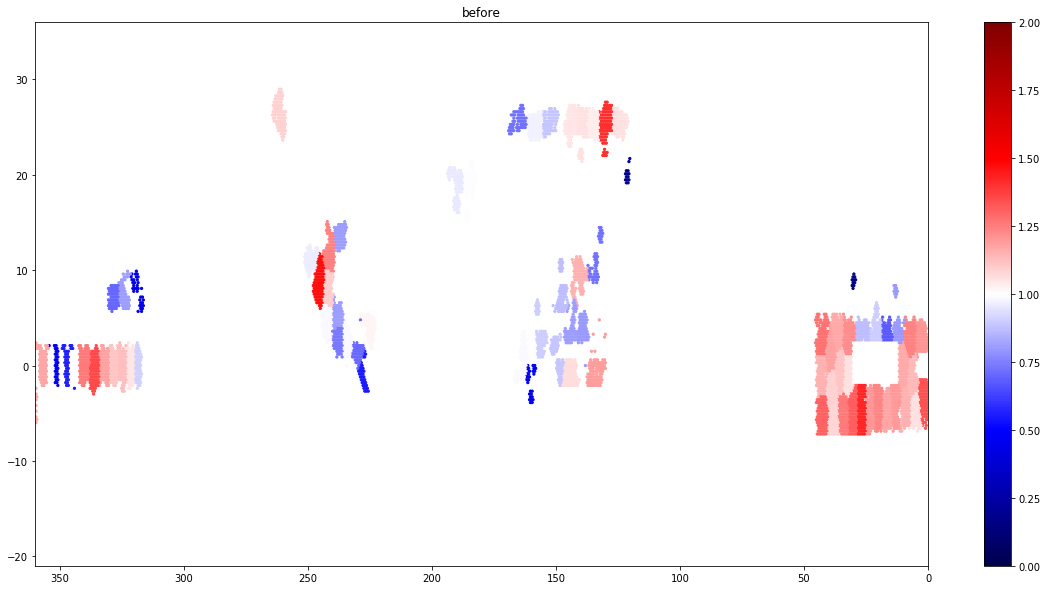

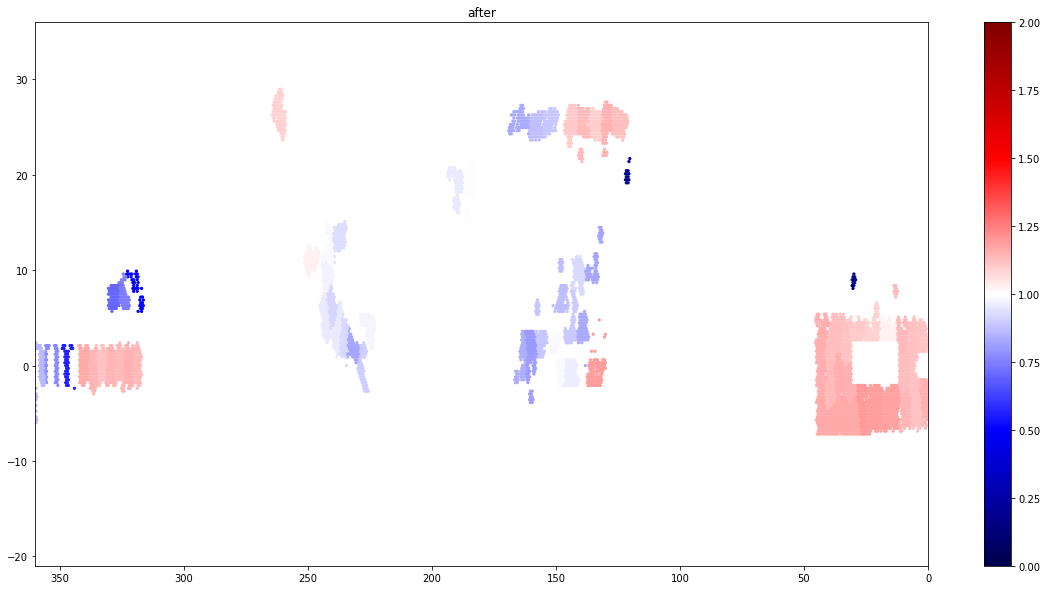

In [35]:
counts_pix_original = group_counts_original[labels]
plt.figure(figsize=(20, 10))
plt.scatter(ra, dec, c=counts_pix_original/optimizer.average_count,
            cmap=plt.cm.seismic, s=5, vmin=0, vmax=2)
plt.colorbar()
plt.axis([360, 0, -21, 36])
plt.title('before')
plt.show()

counts_pix = optimizer.counts[best][optimizer.labels_all[best]]
plt.figure(figsize=(20, 10))
plt.scatter(ra, dec, c=counts_pix/optimizer.average_count,
            cmap=plt.cm.seismic, s=5, vmin=0, vmax=2)
plt.colorbar()
plt.axis([360, 0, -21, 36])
plt.title('after')
plt.show()

4 outlier clusters


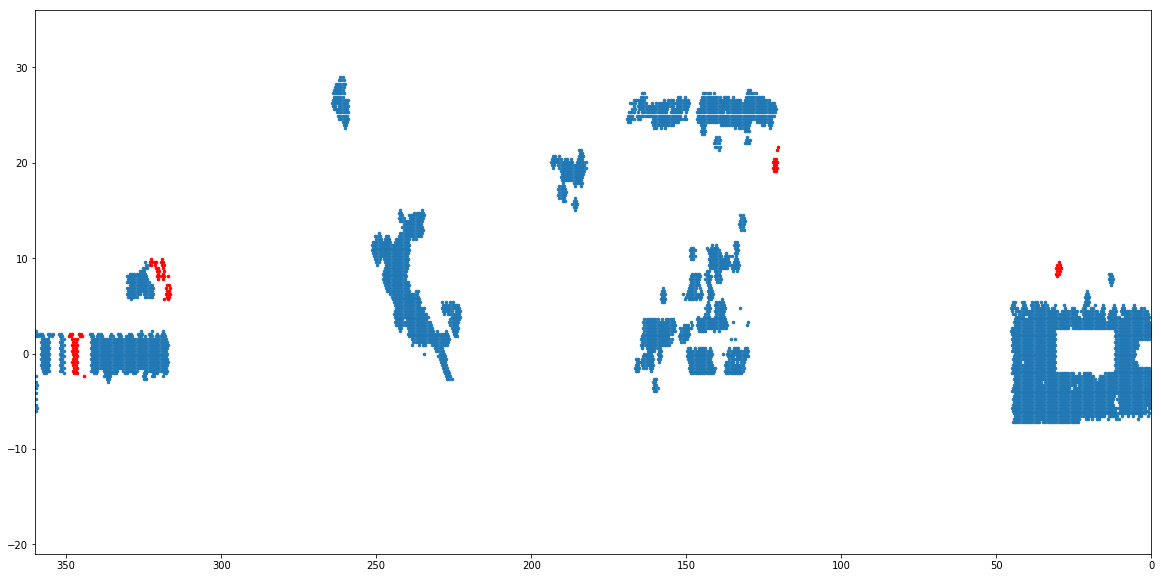

In [36]:
mask_count = optimizer.counts[best]<40000. 
print(np.sum(mask_count), 'outlier clusters')
# print('{:.2f}% objects discarded'.format(np.sum(mask_count)/len(mask_count)*100))
pix_id_ok = np.where(mask_count)[0]
mask_outlier = np.in1d(optimizer.labels_all[best], pix_id_ok)

plt.figure(figsize=(20, 10))
plt.plot(ra[~mask_outlier], dec[~mask_outlier], '.', markersize=5)
plt.plot(ra[mask_outlier], dec[mask_outlier], 'r.', markersize=5)
plt.axis([360, 0, -21, 36])
plt.show()